In [1]:
# Step 1: Clone repo and install packages
!git clone https://github.com/niaz1971/MALARIAL_CELL_CLASSIFICATION_USING_CNN.git
%cd MALARIAL_CELL_CLASSIFICATION_USING_CNN/
!pip install lime kaggle
!pip install -U git+https://github.com/qubvel/classification_models.git

Cloning into 'MALARIAL_CELL_CLASSIFICATION_USING_CNN'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 321 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (321/321), 5.52 MiB | 12.14 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/MALARIAL_CELL_CLASSIFICATION_USING_CNN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=065c0c8128189b0df6ff6f49dc0873e1f5059f5a6ffd3614d6a98774638ee760
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-vbr69xmp
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/clas

In [2]:
# Step 2: Set up Kaggle API for dataset download
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Step 3: Download and unzip malaria cell images dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
100% 674M/675M [00:09<00:00, 77.0MB/s]
100% 675M/675M [00:09<00:00, 71.6MB/s]


In [4]:
# Step 4: Imports
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.image as mpimg

import classification_models.tfkeras
from classification_models.tfkeras import Classifiers

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Step 5: Prepare dataset folders
original_dataset = 'cell_images'
parasitized_dir = os.path.join(original_dataset, 'Parasitized')
uninfected_dir = os.path.join(original_dataset, 'Uninfected')

base_dir = 'malaria_data'
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

classes = ['Parasitized', 'Uninfected']
for split_dir in [train_dir, valid_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [6]:
# Step 6: Split data function
def split_data(source_dir, train_dir, valid_dir, test_dir,
               train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    files = os.listdir(source_dir)
    random.shuffle(files)
    total = len(files)
    train_end = int(total * train_ratio)
    valid_end = train_end + int(total * valid_ratio)

    train_files = files[:train_end]
    valid_files = files[train_end:valid_end]
    test_files = files[valid_end:]

    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))
    for f in valid_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(valid_dir, f))
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(test_dir, f))

# Perform splits for both classes
split_data(parasitized_dir, os.path.join(train_dir, 'Parasitized'),
           os.path.join(valid_dir, 'Parasitized'),
           os.path.join(test_dir, 'Parasitized'))
split_data(uninfected_dir, os.path.join(train_dir, 'Uninfected'),
           os.path.join(valid_dir, 'Uninfected'),
           os.path.join(test_dir, 'Uninfected'))

In [7]:
# Step 7: Data augmentation and generators with ResNet preprocessing
ResNet18, preprocess_input = Classifiers.get('resnet18')

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=40, shear_range=0.2,
                                   width_shift_range=0.4, height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}
print("Class labels:", class_labels)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Class labels: {'Parasitized': 0, 'Uninfected': 1}


In [8]:
# Step 8: Build model with pretrained ResNet18 base (exclude top)
base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(4608, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1152, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 224, 224,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 112, 112,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 112, 112,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 56, 56,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 56, 56,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 56, 56,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 56, 56,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 56, 56,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 56, 56,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 56, 56,    │      4,096 │ stage1_unit1_rel

 Total params: 132,108,875 (503.96 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 11,186,889 (42.67 MB)

In [9]:
# Step 9: Compile model
optimizer = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [10]:
# Step 10: Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
             ModelCheckpoint('best_malaria_model_resnet18.keras', monitor='val_loss', save_best_only=True, verbose=1),
             ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-5)]

In [11]:
# Step 11: Train model
history = model.fit(train_generator, epochs=10, steps_per_epoch=50,
                    validation_data=valid_generator, callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.5637 - loss: 0.9053
Epoch 1: val_loss improved from inf to 0.41969, saving model to best_malaria_model_resnet18.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 869ms/step - accuracy: 0.5656 - loss: 0.9017 - val_accuracy: 0.8066 - val_loss: 0.4197 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7583 - loss: 0.5517
Epoch 2: val_loss improved from 0.41969 to 0.34905, saving model to best_malaria_model_resnet18.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 829ms/step - accuracy: 0.7587 - loss: 0.5508 - val_accuracy: 0.8469 - val_loss: 0.3491 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7642 - loss: 0.5283
Epoch 3: val_loss did not improve from 0.34905
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - accuracy: 0.7646 - loss: 0.5276 - val_accuracy: 0.8244 - val_loss: 0.3986 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - acc

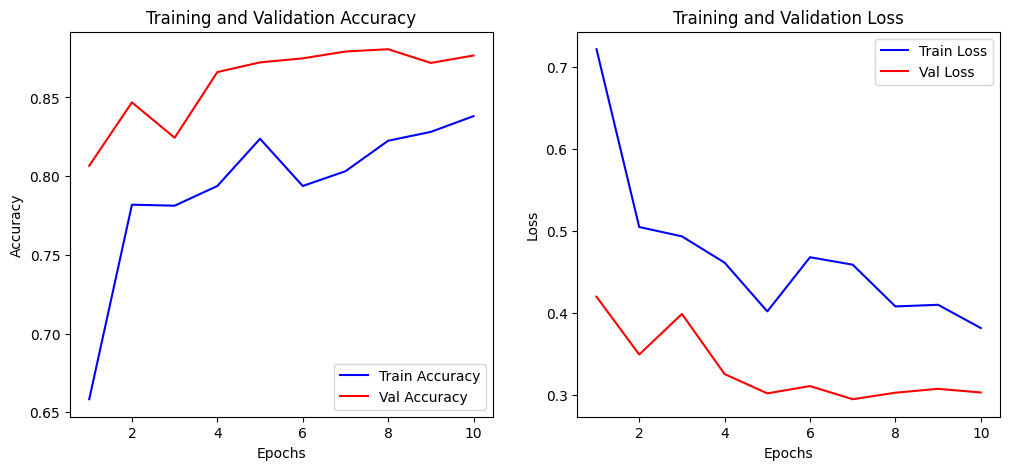

In [12]:
# Step 12: Plot training curves
def plot_training_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(history)

In [13]:
# Step 13: Load best saved model
model = tf.keras.models.load_model('best_malaria_model_resnet18.keras')

In [14]:
# Step 14: Evaluate on validation and test sets
val_loss, val_acc = model.evaluate(valid_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Validation Acc: {val_acc:.4f}, Loss: {val_loss:.4f}')
print(f'Test Acc: {test_acc:.4f}, Loss: {test_loss:.4f}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8849 - loss: 0.2888
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8472 - loss: 0.3132
Validation Acc: 0.8792, Loss: 0.2944
Test Acc: 0.8654, Loss: 0.3066


In [15]:
# Step 15: Predictions and classification report
nb_samples = len(test_generator.filenames)
preds = model.predict(test_generator, steps=nb_samples, verbose=1)
pred_labels = np.argmax(preds, axis=1)

print(classification_report(test_generator.classes, pred_labels,
                            target_names=[class_names[i] for i in range(len(class_names))]))

accuracy = accuracy_score(test_generator.classes, pred_labels)
print(f'Overall Test Accuracy: {accuracy:.4f}')

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step
              precision    recall  f1-score   support

 Parasitized       0.88      0.85      0.86      1378
  Uninfected       0.85      0.88      0.87      1378

    accuracy                           0.87      2756
   macro avg       0.87      0.87      0.87      2756
weighted avg       0.87      0.87      0.87      2756

Overall Test Accuracy: 0.8654


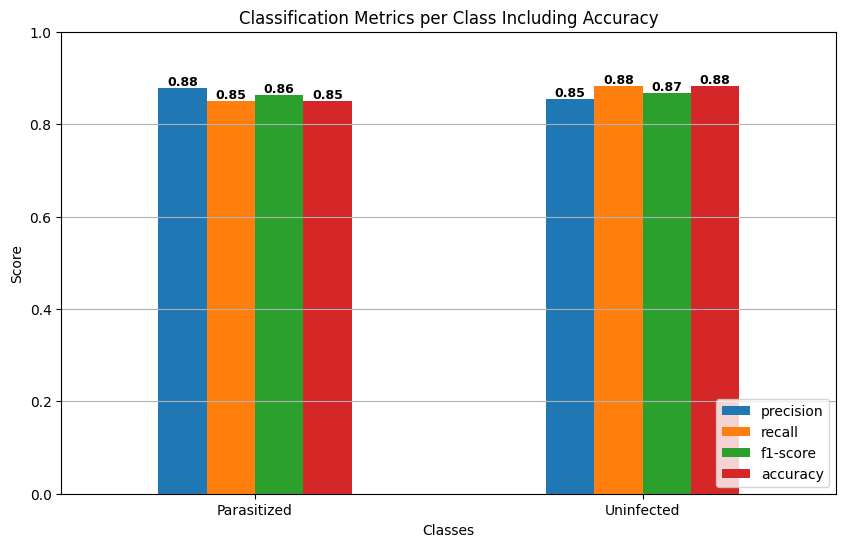


Overall Accuracy: 0.8654


In [16]:
# Step 16: Plot classification metrics
report_dict = classification_report(test_generator.classes, pred_labels,
                                    target_names=[class_names[i] for i in range(len(class_names))],
                                    output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_classes = report_df.iloc[:-3, :-1]

cm = confusion_matrix(test_generator.classes, pred_labels)
class_acc = cm.diagonal() / cm.sum(axis=1)
report_classes['accuracy'] = class_acc

ax = report_classes[['precision', 'recall', 'f1-score', 'accuracy']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Metrics per Class Including Accuracy')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim([0,1])
plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x()+p.get_width()/2, height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

print(f"\nOverall Accuracy: {accuracy:.4f}")

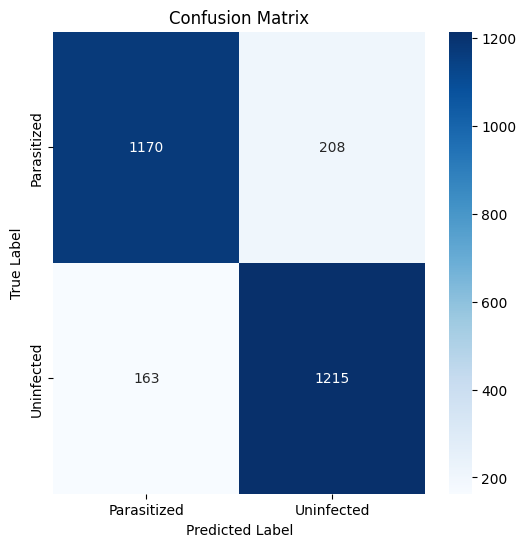

In [17]:
# Step 17: Confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names.values(), yticklabels=class_names.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

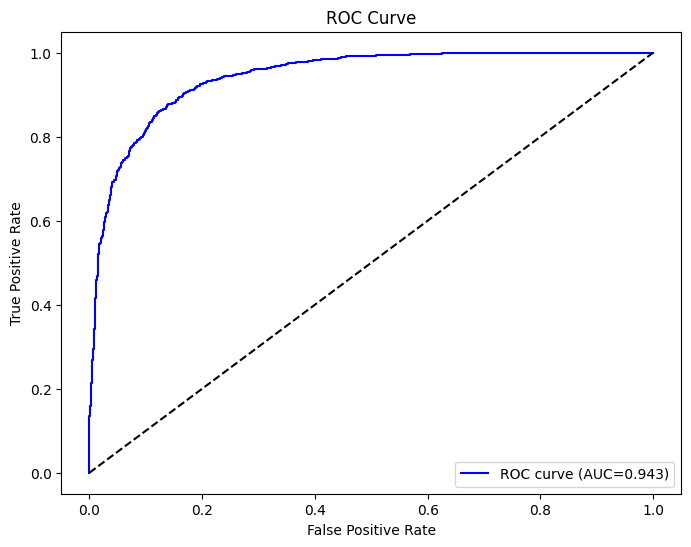

In [18]:
# Step 18: ROC curve
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, 'b-', label=f'ROC curve (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


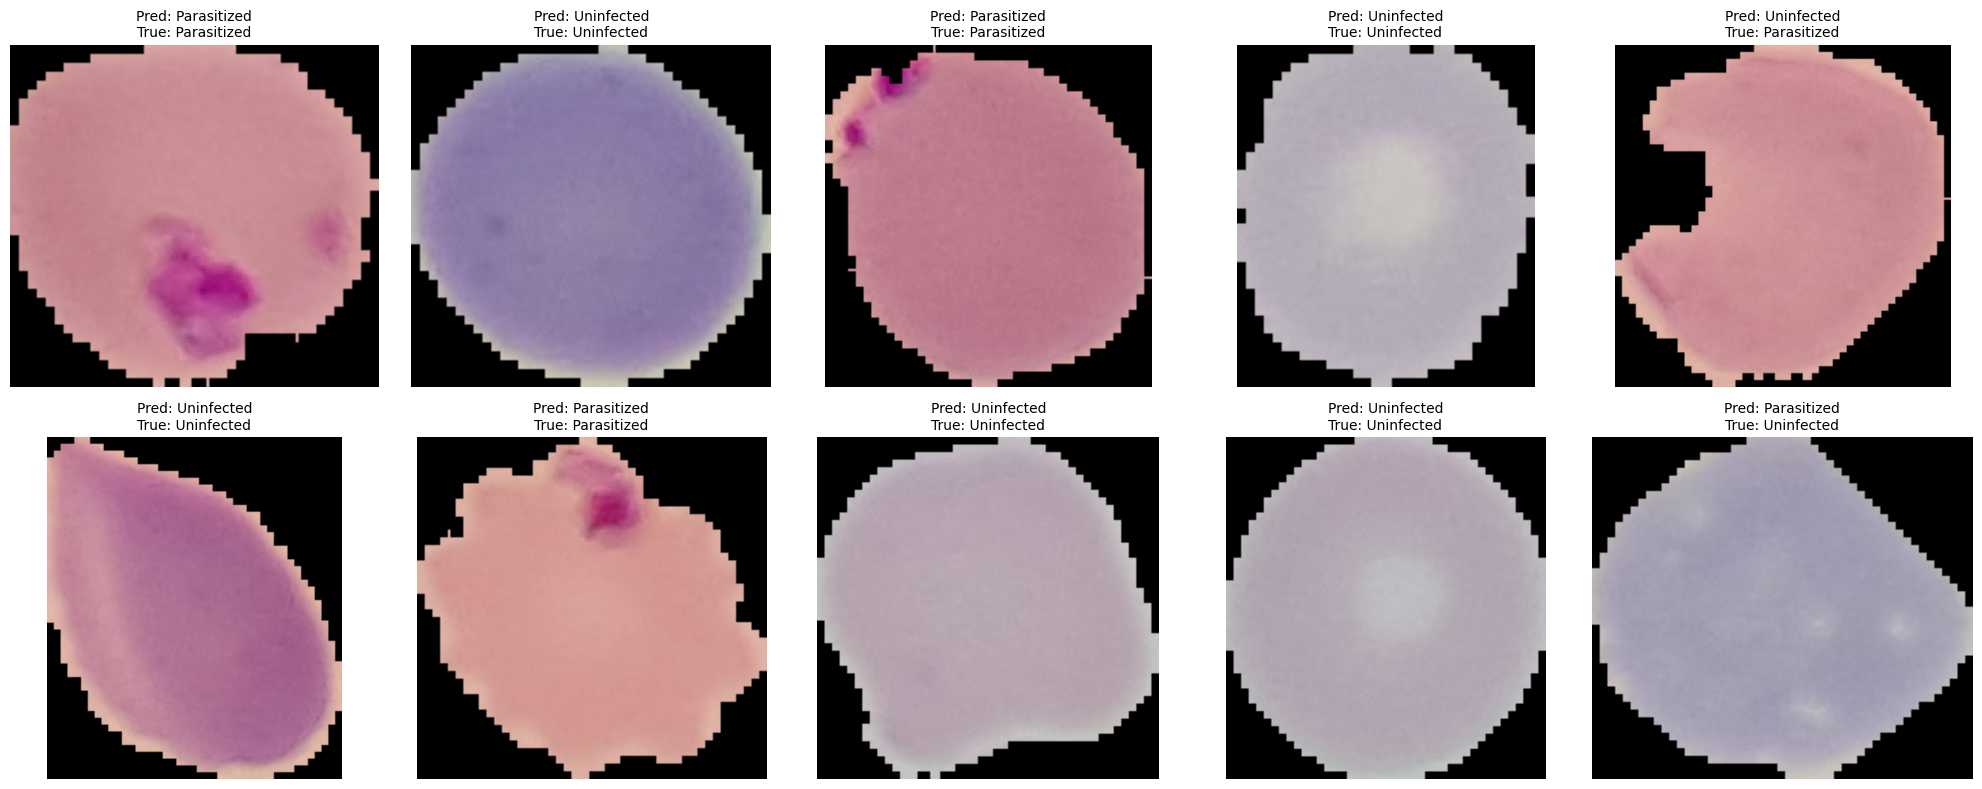

In [19]:
# Step 19: Visualize test images with predictions
sample_files = random.sample(test_generator.filenames, 10)
plt.figure(figsize=(20,8))
for i, fname in enumerate(sample_files):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(test_dir, fname)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    img_obj = load_img(img_path, target_size=(224,224))
    img_arr = img_to_array(img_obj)
    img_exp = np.expand_dims(img_arr, axis=0)
    pred = model.predict(img_exp)
    pred_label = class_names[np.argmax(pred)]
    true_label = os.path.basename(os.path.dirname(img_path))
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', fontsize=10)
plt.tight_layout()
plt.show()